# Python SHAP Model Interpretation
Adapted from the SHAP repository.

In [1]:
#pip install --upgrade shap
import shap

import catboost
from catboost import *

#for the first model
import xgboost

import pandas as pd
import numpy as np

shap.initjs() #to enable visualization

Let's first explore shap values for dataset with numeric features. **In this tutorial we do not focus on best/correct model training**. We use the Boston House Price Dataset:
- CRIM per capita crime rate by town
- ZN proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS proportion of non-retail business acres per town
- CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX nitric oxides concentration (parts per 10 million)
- RM average number of rooms per dwelling
- AGE proportion of owner-occupied units built prior to 1940
- DIS weighted distances to five Boston employment centres
- RAD index of accessibility to radial highways
- TAX full-value property-tax rate per 10000 dollars
- PTRATIO pupil-teacher ratio by town
- B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT percentage lower status of the population
- MEDV Median value of owner-occupied homes in $1000’s

In [2]:
#Boston House Prices Data
X,y = shap.datasets.boston()

#XGBoost matrix
xgb_full = xgboost.DMatrix(X, label=y)

In [3]:
#Train XGBoost Model on FULL DATASET
#!Same dataset is also used for early stopping
#Train final model on the FULL data set
#Cox-survival objective function
params = {
    "eta": 0.002,
    "max_depth": 3, 
    "objective": "reg:squarederror",
    "subsample": 0.8
}
model = xgboost.train(params, xgb_full, 5000, evals = [(xgb_full, "test")], verbose_eval=1000)

[0]	test-rmse:23.8268
[1000]	test-rmse:4.4634
[2000]	test-rmse:2.2946
[3000]	test-rmse:1.90205
[4000]	test-rmse:1.6809
[4999]	test-rmse:1.51523


#### Calculate Shap Values

In [4]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### Explain Single Predictions

In [5]:
# Force Plot of first prediction
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

The same can be visualized through a waterfall plot

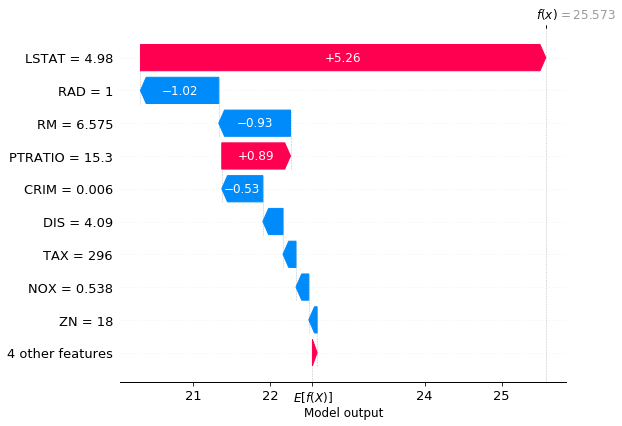

In [6]:
# Waterfall Plot
shap.waterfall_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

Can also be done with decision plots (feature values for the specific observation are also reported).

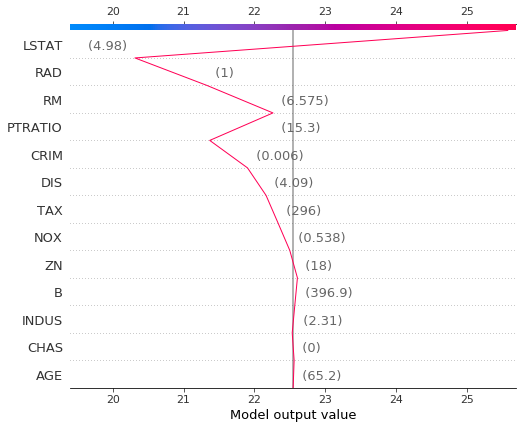

In [7]:
shap.decision_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

### Global Importance
To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). This reveals for example that a high LSTAT (% lower status of the population) lowers the predicted home price.

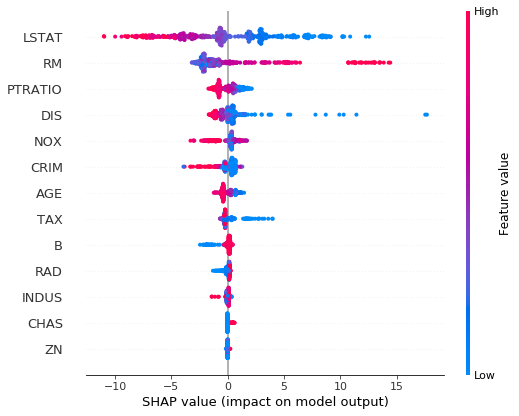

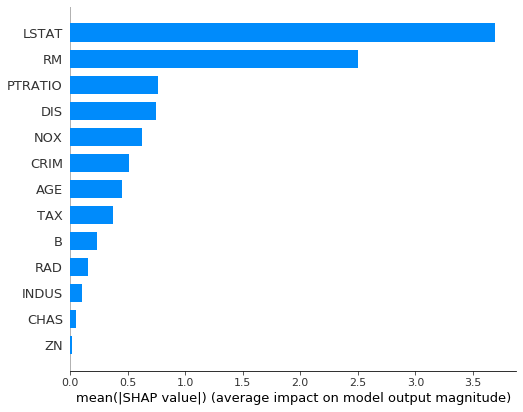

In [8]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

# summarize the effects of all the features
shap.summary_plot(shap_values, X, plot_type = "bar")

### Decision Plots
Shows the impact of each feature on each prediction path. **hclust** ordering often provides better visualization.

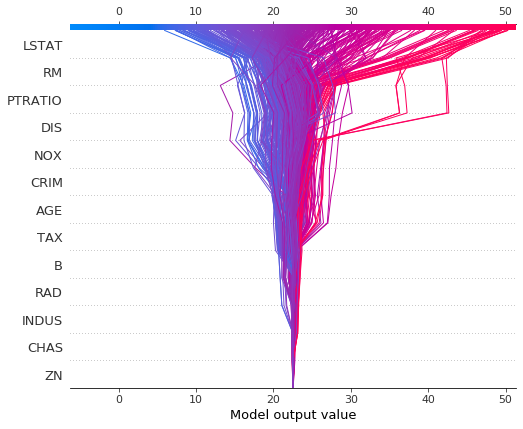

In [11]:
#Use ignore_warnings=True to plot many observations (may be slow)
#Other feature ordering is possible feature_order='hclust'
shap.decision_plot(explainer.expected_value, shap_values, X) 

### Dependence Plots
While a SHAP summary plot gives a general overview of each feature a SHAP dependence plot show how the model output varies by feauture value. Note that every dot is an observation, and the vertical dispersion at a single feature value results from interaction effects in the model. The feature used for coloring is automatically chosen to highlight what might be driving these interactions. Later we will see how to check that the interaction is really in the model with SHAP interaction values. 

In this case coloring by RAD (index of accessibility to radial highways) highlights that RM has less impact on home price for areas close to radial highways.

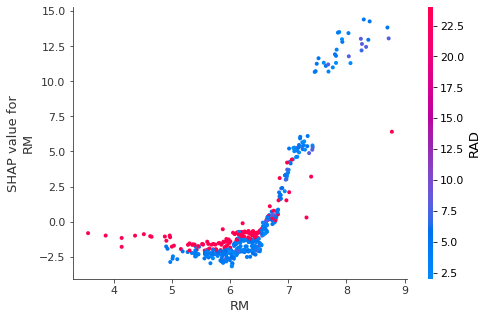

In [13]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("RM", shap_values, X)

### Inteaction Plots
The main effect is separated from the interactions (this is the reason why in the main effect graph there is little vertical dispersion).

In [14]:
#Calculate SHAP interaction values (Catboost still has a problem with this)
#Can be very slow
shap_interaction_values = explainer.shap_interaction_values(X)

In [15]:
#Main
shap.dependence_plot(("RM", "RM"), shap_interaction_values, X)

#! Should work but returns an error. Probably a bug in shap.

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [16]:
#Interaction
shap.dependence_plot(("RM", "TAX"), shap_interaction_values, X) 

#! Should work but returns an error. Probably a bug in shap.

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## With Categorical Features
You can also use shap values to analyze importance of categorical features. Here we use **Catboost**.

In [17]:
#Use Titanic data (binary, survived or not)
df = pd.read_csv("https://raw.githubusercontent.com/iandreafc/sna-bigdata-course/master/Datasets/titanic.csv")
y = df.Survived
X = df.drop('Survived', axis=1)

#Replace NANs
df.fillna(-999, inplace=True)

#Encode strings
for var in ['Sex', 'Cabin', 'Embarked']:
    X[var] = X[var].astype('category').cat.codes
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,22.0,1,0,7.2500,-1,2
1,1,0,38.0,1,0,71.2833,81,0
2,3,0,26.0,0,0,7.9250,-1,2
3,1,0,35.0,1,0,53.1000,55,2
4,3,1,35.0,0,0,8.0500,-1,2


In [18]:
print(X.dtypes)
cat_features = np.where(X.dtypes != np.float)[0]
cat_features

Pclass        int64
Sex            int8
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Cabin         int16
Embarked       int8
dtype: object


array([0, 1, 3, 4, 6, 7], dtype=int64)

In [19]:
model = CatBoostClassifier(random_seed=14)
model.fit(X, y, cat_features=cat_features, verbose=False, plot=False)

In [20]:
#When the SHAP Explainer has problems
#explainer = shap.TreeExplainer(model)
#shap_values = explainer.shap_values(Pool(X, y, cat_features=cat_features))

#Use Catboost to calculate Shap Values
pool = Pool(X, label=y, cat_features = cat_features)
shap_values = model.get_feature_importance(type="ShapValues", data = pool)
shap_values = shap_values[:,:-1]
shap_values_df = pd.DataFrame(shap_values, columns=X.columns.values)


Explain single predictions.

In [21]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In the summary plot below you can see that absolute values of the features do not matter (when categorical). But it is clear from the plot what is the effect of different features.

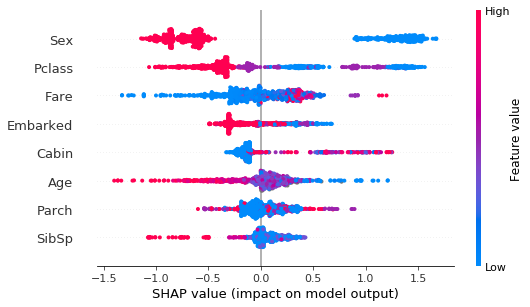

In [22]:
shap.summary_plot(shap_values, X)

## Multiclass Example

In [23]:
model = CatBoostClassifier(loss_function = 'MultiClass', random_seed=14)
model.fit(X, y, cat_features=cat_features, verbose=False, plot=False)

In [24]:
#explainer = shap.TreeExplainer(model)
#shap_values = explainer.shap_values(Pool(X, y, cat_features=cat_features))

#When SHAP explainer gives errors
shap_values = model.get_feature_importance(type="ShapValues", data = pool)
shap_values = shap_values.transpose(1,0,2)
shap_values = list(shap_values[:,:,:-1])
shap_values_df = pd.DataFrame(np.sum([np.mean(np.absolute(x), axis=0) for x in shap_values], axis=0)).T
shap_values_df.columns = X.columns.values

Summary plot of SHAP values for formula raw predictions **for class 0**

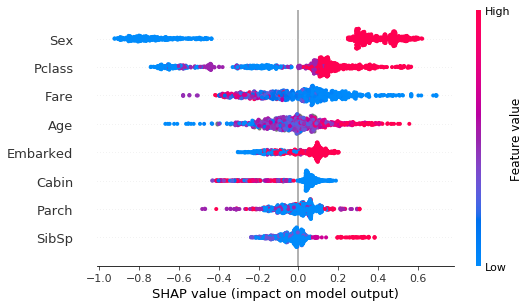

In [25]:
shap.summary_plot(shap_values[0], X)

and **for class 1**.

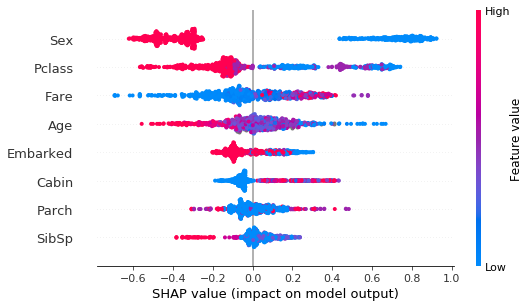

In [26]:
shap.summary_plot(shap_values[1], X)

Or together.

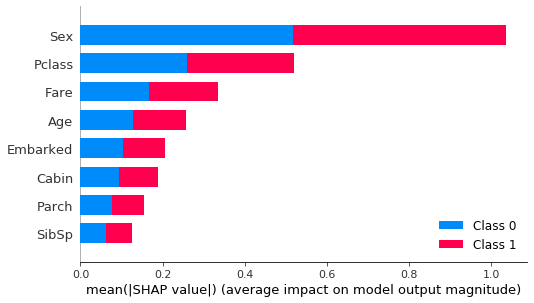

In [27]:
shap.summary_plot(shap_values, X)